In [ ]:
# NOTE: Parts of code are re-purposed from shared tutorials in-class

import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Implementation of Q-Learning Agent and SARSA Agent

Differences between SARSA and Q-Learning Algorithms Implemented with respect to following explanation from StackOverflow: https://stackoverflow.com/questions/6848828/what-is-the-difference-between-q-learning-and-sarsa

In particular, excerpted from the answer of the posting:

1. The most important difference between the two is how Q is updated after each action. SARSA uses the Q' following a ε-greedy policy exactly, as A' is drawn from it. In contrast, Q-learning uses the maximum Q' over all possible actions for the next step. This makes it look like following a greedy policy with ε=0, i.e. NO exploration in this part.

2. However, when actually taking an action, Q-learning still uses the action taken from a ε-greedy policy. This is why "Choose A ..." is inside the repeat loop.

3. Following the loop logic in Q-learning, A' is still from the ε-greedy policy.



In [ ]:
class QL_Agent():
  """Initializes Q-learning agent."""
  def __init__(self, environment, actions, epsilon=0.05, alpha=0.1, gamma=1):
    self.environment = environment
    self.actions = actions
    # All Q-values to be stored in a dictionary of dictionaries
    self.q_table = dict()

    # Set initial Q-values (all to 0)
    for i in range(self.environment.height):
      for j in range(self.environment.width):
        self.q_table[(i, j)] = {}
        for action in self.actions:
          self.q_table[(i, j)][action] = 0

    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma


  """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
  Will make an exploratory random action dependent on epsilon."""
  def choose_action(self, available_actions):
    # Explore, i.e., choosing a path the agent is not sure about and possibly learning more
    if np.random.uniform(0,1) < self.epsilon:
      action = available_actions[np.random.randint(0, len(available_actions))]
    # Exploit, i.e., choosing a path that is known and close to what is expected
    else:
        q_values_state = self.q_table[self.environment.current_location]
        # Choose maximum Q-value from Q-values associated with state (and available actions)
        max_q_value = max(q_values_state.values())
        # Select action relevant to maximum Q-value
        # Random action is selected if multiple choices are presented
        action = np.random.choice([k for k, v in q_values_state.items() if v == max_q_value])
    return action


  """Updates the Q-value table using Q-learning."""
  def learn(self, old_state, reward, new_state, action):
    q_values_state = self.q_table[new_state]
    max_q_value_in_new_state = max(q_values_state.values())
    current_q_value = self.q_table[old_state][action]

    self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)


In [ ]:
class SARSA_Agent():
  """Initializes SARSA agent."""
  def __init__(self, environment, actions, epsilon=0.05, alpha=0.1, gamma=1):
    self.environment = environment
    self.actions = actions
    # All Q-values to be stored in a dictionary of dictionaries
    self.q_table = dict()

    # Set initial Q-values (all to 0)
    for i in range(self.environment.height):
      for j in range(self.environment.width):
        self.q_table[(i, j)] = {}
        for action in self.actions:
          self.q_table[(i, j)][action] = 0

    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma

  """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
  Will make an exploratory random action dependent on epsilon."""
  def choose_action(self, location, available_actions):
    # Explore, i.e., choosing a path the agent is not sure about and possibly learning more
    if np.random.uniform(0,1) < self.epsilon:
      action = available_actions[np.random.randint(0, len(available_actions))]
    # Exploit, i.e., choosing a path that is known and close to what is expected
    else:
        q_values_state = self.q_table[location]
        # Choose maximum Q-value from Q-values associated with state (and available actions)
        max_q_value = max(q_values_state.values())
        # Select action relevant to maximum Q-value
        # Random action is selected if multiple choices are presented
        action = np.random.choice([k for k, v in q_values_state.items() if v == max_q_value])
    return action


  """Updates the Q-value table using Q-learning."""
  def learn(self, old_state, reward, new_state, action):
    q_values_state = self.q_table[new_state]
    current_q_value = self.q_table[old_state][action]

    # Derive next action for new state
    next_action = self.choose_action(new_state, self.environment.actions)

    self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * self.q_table[new_state][next_action])


# Define `play()` function (i.e., algorithm which runs iterations of the agent through the environment and documents cumulative reward per episode

In [ ]:
"""The `play()` function runs iterations and updates Q-values if desired."""
def play(environment, agent, ql_agent=True, trials=500, max_steps_per_episode=1000, learn=False):
    # List of reward per episode
    reward_per_episode = []
    optimal_policy = [environment.current_location]

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            if not ql_agent:
              action = agent.choose_action(environment.current_location, environment.actions)
            else:
              action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
              agent.learn(old_state, reward, new_state, action)
            else:
              optimal_policy.append(new_state)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
              environment.__init__()
              game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    if learn == True:
      return reward_per_episode # Return performance log
    elif learn == False:
      return (reward_per_episode, optimal_policy)

# Normal moves with deterministic wind

In [ ]:
class Normal_Moves_With_Deterministic_Wind():

  """Initialize Grid World in which normal moves are permitted and wind is deterministic"""
  def __init__(self):
    # Set information about the gridworld
    self.height = 7
    self.width = 10
    self.grid = np.zeros((self.height, self.width)) - 1 # Create a height x width matrix full of -1 rewards
    self.wind_effect_vec = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

    # Set start location for the agent
    # Location (n1, n2), where n1 indexes position on height dimension
    # and n2 indexes position on width dimension
    self.current_location = (3, 0)

    self.gold_location = (3, 7)
    self.terminal_states = [self.gold_location]

    # Set grid rewards for special cells
    self.grid[self.gold_location[0], self.gold_location[1]] = 10

    # Set available actions
    self.actions = ["NORTH", "SOUTH", "WEST", "EAST"]

  """Returns possible actions"""
  def get_available_actions(self):
      return self.actions

  """Prints out current location of the agent on the grid (used for debugging)"""
  def agent_on_map(self): # turned 2D coordinates into a "map"
      grid = np.zeros((self.height, self.width))
      grid[self.current_location[0], self.current_location[1]] = 1
      return grid

  """Returns the reward for an input position"""
  def get_reward(self, new_location):
      return self.grid[new_location[0], new_location[1]]

  """Moves the agent in the specified direction. If agent is at a border, agent stays still
     but takes negative reward. Function returns the reward for the move."""
  def make_step(self, action):
      # Store previous location
      last_location = self.current_location

      current_wind_effect = self.wind_effect_vec[self.current_location[1]]

      if action == 'NORTH':
        new_location = (self.current_location[0] - 1 - current_wind_effect, self.current_location[1])
      elif action == 'SOUTH':
        new_location = (self.current_location[0] + 1 - current_wind_effect, self.current_location[1])
      elif action == 'WEST':
        new_location = (self.current_location[0] - current_wind_effect, self.current_location[1] - 1)
      elif action == 'EAST':
        new_location = (self.current_location[0] - current_wind_effect, self.current_location[1] + 1)


      # Only modify current location to the extent that it is a possibility
      if (new_location[0] <= (self.height - 1)) and (new_location[0] >= 0):
          self.current_location = (new_location[0], self.current_location[1])
      if (new_location[1] <= (self.width - 1)) and (new_location[1] >= 0):
          self.current_location = (self.current_location[0], new_location[1])

      reward = self.get_reward(self.current_location)

      return reward

  def check_state(self):
      """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
      if self.current_location in self.terminal_states:
          return 'TERMINAL'

# King's moves with stochastic Wind

In [ ]:
class King_Moves_With_Deterministic_Wind():

  """Initialize Grid World in which normal moves are permitted and wind is deterministic"""
  def __init__(self):
    # Set information about the gridworld
    self.height = 7
    self.width = 10
    self.grid = np.zeros((self.height, self.width)) - 1 # Create a height x width matrix full of -1 rewards
    self.wind_effect_vec = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

    # Set start location for the agent
    # Location (n1, n2), where n1 indexes position on height dimension
    # and n2 indexes position on width dimension
    self.current_location = (3, 0)

    self.gold_location = (3, 7)
    self.terminal_states = [self.gold_location]

    # Set grid rewards for special cells
    self.grid[self.gold_location[0], self.gold_location[1]] = 10

    # Set available actions
    self.actions = ["NORTH", "NORTHEAST", "NORTHWEST", "SOUTH", "SOUTHEAST", "SOUTHWEST",
                    "WEST", "EAST"]

  """Returns possible actions"""
  def get_available_actions(self):
      return self.actions

  """Prints out current location of the agent on the grid (used for debugging)"""
  def agent_on_map(self): # turned 2D coordinates into a "map"
      grid = np.zeros((self.height, self.width))
      grid[self.current_location[0], self.current_location[1]] = 1
      return grid

  """Returns the reward for an input position"""
  def get_reward(self, new_location):
      return self.grid[new_location[0], new_location[1]]

  """Moves the agent in the specified direction. If agent is at a border, agent stays still
     but takes negative reward. Function returns the reward for the move."""
  def make_step(self, action):
      # Store previous location
      last_location = self.current_location

      current_wind_effect = self.wind_effect_vec[self.current_location[1]]

      if action == 'NORTH':
        new_location = (self.current_location[0] - 1 - current_wind_effect, self.current_location[1])
      if action == 'NORTHWEST':
        new_location = (self.current_location[0] - 1 - current_wind_effect, self.current_location[1] - 1)
      if action == 'NORTHEAST':
        new_location = (self.current_location[0] - 1 - current_wind_effect, self.current_location[1] + 1)
      elif action == 'SOUTH':
        new_location = (self.current_location[0] + 1 - current_wind_effect, self.current_location[1])
      elif action == 'SOUTHEAST':
        new_location = (self.current_location[0] + 1 - current_wind_effect, self.current_location[1] + 1)
      elif action == 'SOUTHWEST':
        new_location = (self.current_location[0] + 1 - current_wind_effect, self.current_location[1] - 1)
      elif action == 'WEST':
        new_location = (self.current_location[0] - current_wind_effect, self.current_location[1] - 1)
      elif action == 'EAST':
        new_location = (self.current_location[0] - current_wind_effect, self.current_location[1] + 1)


      # Make a random choice of A, B, or C; each category pertains to different stochastic wind effects
      step_choice = np.random.choice(["A", "B", "C"], p = [1/3, 1/3, 1/3])

      if step_choice == "A":
        new_location = new_location
      elif step_choice == "B":
        new_location = (new_location[0] + 1, new_location[1])
      elif step_choice == "C":
        new_location = (new_location[0] + 2, new_location[1])

      # Only modify current location to the extent that it is a possibility
      if (new_location[0] <= (self.height - 1)) and (new_location[0] >= 0):
          self.current_location = (new_location[0], self.current_location[1])
      if (new_location[1] <= (self.width - 1)) and (new_location[1] >= 0):
          self.current_location = (self.current_location[0], new_location[1])

      reward = self.get_reward(self.current_location)

      return reward

  def check_state(self):
      """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
      if self.current_location in self.terminal_states:
          return 'TERMINAL'

# Some testing

In [ ]:
env = Normal_Moves_With_Deterministic_Wind()
# env = King_Moves_With_Deterministic_Wind()

In [ ]:
print(env.grid.shape)

(7, 10)


In [ ]:
ql_agent = QL_Agent(environment=env, actions=env.actions)

In [ ]:
print("Current position of the agent =", env.current_location)

Current position of the agent = (3, 0)


In [ ]:
print(env.agent_on_map())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)

Available_actions = ['NORTH', 'SOUTH', 'WEST', 'EAST']


In [ ]:
chosen_action = ql_agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)

Randomly chosen action = WEST


In [ ]:
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)

Reward obtained = -1.0


In [ ]:
print("Current position of the agent =", env.current_location)

Current position of the agent = (3, 0)


In [ ]:
print(env.agent_on_map())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# **Experiments / Results of algorithms implemented, i.e., part two of report**

Parameters of interest that we vary are **alpha, epsilon, and gamma**

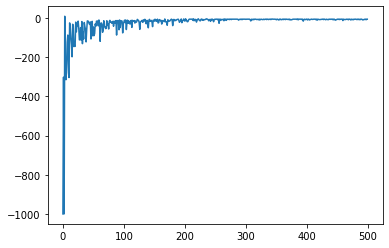

In [ ]:
# Initialize environment and agent
environment = Normal_Moves_With_Deterministic_Wind()
ql_agent = QL_Agent(environment, environment.actions)

reward_per_episode = play(environment, ql_agent, ql_agent=True, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [ ]:
# Optimal policy
data = play(environment, ql_agent, ql_agent=True, trials=1, learn=False)
print(data[1])

[(3, 0), (3, 1), (4, 1), (4, 2), (5, 2), (5, 3), (4, 4), (3, 5), (2, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


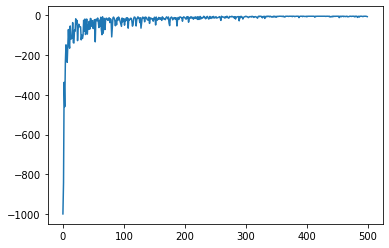

In [ ]:
# Initialize environment and agent
environment = Normal_Moves_With_Deterministic_Wind()
sarsa_agent = SARSA_Agent(environment, environment.actions)

reward_per_episode = play(environment, sarsa_agent, ql_agent=False, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [ ]:
# Optimal policy
data = play(environment, sarsa_agent, ql_agent=False, trials=1, learn=False)
print(data[1])

[(3, 0), (3, 1), (3, 2), (3, 3), (2, 4), (0, 4), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


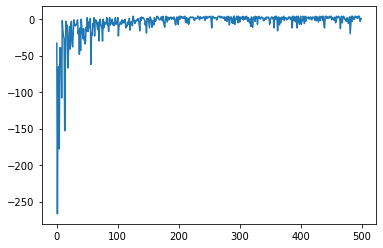

In [ ]:
# Initialize environment and agent
environment = King_Moves_With_Deterministic_Wind()
ql_agent = QL_Agent(environment, environment.actions)

reward_per_episode = play(environment, ql_agent, ql_agent=True, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [ ]:
# Optimal policy
data = play(environment, ql_agent, ql_agent=True, trials=1, learn=False)
print(data[1])

[(3, 0), (2, 1), (4, 2), (6, 3), (6, 4), (6, 5), (4, 6), (4, 7), (3, 7)]


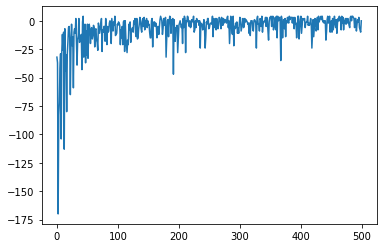

In [ ]:
# Initialize environment and agent
environment = King_Moves_With_Deterministic_Wind()
SARSA_Agent = SARSA_Agent(environment, environment.actions)

reward_per_episode = play(environment, SARSA_Agent, ql_agent=False, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [ ]:
# Optimal policy
data = play(environment, SARSA_Agent, ql_agent=False, trials=1, learn=False)
print(data[1])

[(3, 0), (3, 1), (4, 2), (6, 3), (6, 4), (5, 5), (4, 6), (4, 7), (2, 8), (3, 7)]
